In [ ]:
pip install tracywidom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tracywidom: filename=TracyWidom-0.3.0-py3-none-any.whl size=11749 sha256=4256308f9068f97f4704ff668f95e7e98d365c48a84b49c2c4c13ffe96b619ff
  Stored in directory: /root/.cache/pip/wheels/3e/6f/a8/d660d4df8640d2a67bebf969d3990d78f584b1603d416be7c6
Successfully built tracywidom


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
import scipy
from scipy.integrate import quad
from TracyWidom import TracyWidom

The next block contains all the code necessary to create the neural network

In [ ]:
class networkModel(nn.Module):
  def __init__(self, without_rel, dims):
    super(networkModel, self).__init__()
    self.without_rel = without_rel
    self.fc = nn.ModuleList()
    self.dims = dims
    current_dim = dims[0]
    for i in range(1, len(dims)):
      X = nn.Linear(current_dim, dims[i], bias=True)
      self.fc.append(X)
      current_dim = dims[i]
  
  def forward(self, x):
    x = torch.flatten(x,start_dim=2)
    for j in range(len(self.fc)):
      x = self.fc[j](x)
      if not self.without_rel[j]:
        x = F.relu(x)
    x = torch.flatten(x, start_dim = 1)
    x = F.log_softmax(x, dim=1)
    return (x)

  def getLayers(self):
    return len(self.fc)

  def getLayerMatrix(self,index):
    layerMatrix = torch.as_tensor(self.fc[index].weight)
    layerMatrix = layerMatrix.cpu()
    layerMatrix = layerMatrix.detach().numpy()
    return layerMatrix

  def getWithout(self):
    return self.without_rel
   
  def getDims(self):
    return self.dims
  
  def getParameterCount(self):
    count = 0
    for param in self.parameters():
      temp = 1
      param = param.size()
      for i in param: temp *= i
      count += temp
    return count

def train(args, m, device, train_loader, optimizer, epoch, showTrainingLoss = True):
  m.train()
  i = 1
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    i+=1
    correct = 0
    optimizer.zero_grad()
    (output) = m(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if i % args['log_interval'] == 0 and showTrainingLoss:
      print(f'Train Epoch: {epoch} [{ batch_idx *len(data)}/{ len(train_loader.dataset)} ({100. *batch_idx/ len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
  return (0)


def test(args, m, device, test_loader):
  m.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      (output) = m(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader)
  print(f'test set: Average loss: {test_loss:4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100.*correct/len(test_loader.dataset):.0f}%)')
  return (100 * correct / len(test_loader.dataset))



def neuralInit(seed, device, model, lr, momentum, batchSize):
  args = {"batch_size": batchSize, "test_batch_size": batchSize,  "lr": lr, "momentum": momentum,  "no_cuda": 'false',  "seed": seed,  "log_interval":50}
  use_cuda = not args['no_cuda'] and torch.cuda.is_available()
  torch.manual_seed(seed)
  kwargs = {'num_workers': 1, 'pin_memory':True} if use_cuda else{}

  #Load training data
  train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data',train=True, 
      download=True, transform=transforms.Compose([transforms.ToTensor()])), batch_size=args['batch_size'], shuffle=True, **kwargs)
  
  #Load test data
  test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([transforms.ToTensor()])), batch_size=args['test_batch_size'], shuffle=True, **kwargs)
  
  optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  

  return (args, model ,optimizer, test_loader, train_loader)


The next block contains all the code necessary to find lambda_+ according to the BEMA algorithm

In [ ]:
def mpDensity(ndf, pdim, var = 1):
  gamma = ndf/pdim
  inv_gamma_sqrt = math.sqrt(1/gamma)
  a = var*(1-inv_gamma_sqrt)**2
  b = var*(1+inv_gamma_sqrt)**2
  return a,b

def dmp(x, ndf, pdim, var=1, log = False):
  gamma = ndf/pdim

  a,b = mpDensity(ndf, pdim, var)

  if not log :
    # we have to handle +/- zero carefully when gamma=1
    if gamma == 1 and x == 0 and 1/x > 0:
      d = math.inf
    elif x <= a and x >= b:
      d = 0
    else:
      d = gamma/( 2*math.pi*var*x ) * math.sqrt( ( x-a )*( b-x ) )
  else:
    if gamma == 1 and x == 0 and 1/x > 0:
      d = math.inf
    elif x <= a and x >= b:
      d = -math.inf
    else:
      d = log( gamma ) - ( log( 2 ) + log( math.pi ) + log( var ) + log( x ) ) + 0.5*log( x-a ) + 0.5*log( b-x )
      
  return d

def pmp(q, ndf, pdim, var=1, lower_tail = True, log_p = False):
  gamma = ndf/pdim
  a,b = mpDensity(ndf, pdim, var)
  f = lambda x : dmp(x, ndf, pdim, var)
  if lower_tail:
    if q<=a:
      p = 0
    elif q>=b:
      p = 1
    else:
      p = quad(f,a,q)[0]
    if gamma < 1 and q >= 0:
      p+= (1 - gamma)
  else:
    if q<=a:
      p = min(1, gamma)
    elif q>=b:
      p = 0
    else:
      p = quad(f,q,b)[0]
    if gamma < 1 and q <= 0:
      p+= (1 - gamma)
  if log_p:
    res = math.log(p)
  else:
    res = p
  return res    
  
def qmp(p, ndf, pdim, var=1, lower_tail = True, log_p = False ):
  svr = ndf/pdim
  if lower_tail:
    p = p
  else:
    p = 1- p
  if log_p:
    p = math.exp(p)
  a,b = mpDensity(ndf, pdim, var)
  q = None
  if p<=0:
    if svr <=1:
      q = -0
    else:
      q = a
  else:
    if p>=1:
      q = b
  if svr<1:
    if p<1-svr:
      q = -0
    else:
      if p == 1-svr:
        q = 0
  if q is None:
    F = lambda x: pmp(x,ndf, pdim, var) - p
    q = scipy.optimize.brentq(F, a, b)
  return q



#bema_inside is where the BEMA algorithm is calculated
#use bema_mat_wrapper instead
def bema_inside(pdim, ndf, eigs, alpha, beta):
  pTilde = min(pdim,ndf)
  gamma = pdim/ndf
  ev = np.sort(eigs)
  ind = list(range(int(alpha*pTilde), int((1-alpha)*pTilde)))
  num =0 
  q = [qmp(i/pTilde, ndf, pdim, 1) for i in ind]
  lamda = [ev[i] for i in ind]
  num = np.dot(q, lamda)
  denum = np.dot(q,q)
  sigma_sq = num/denum
  tw1 = TracyWidom(beta=1)
  t_b =tw1.cdfinv(1-beta)
  lamda_plus = sigma_sq*(((1+np.sqrt(gamma))**2+t_b*ndf**(-2/3)*(gamma)**(-1/6)*(1+np.sqrt(gamma))**4/3))
  l2 = sigma_sq* (1+np.sqrt(gamma))**2
  return sigma_sq, lamda_plus, l2


#use this function to compute bema
def bema_mat_wrapper(matrix,pReal,nReal, alpha, beta, goodnessOfFitCutoff, show = False):
    #this block uses the fact that eigenvalues are invariant under transposition
    #and hence without loss of generality our input matrix is p x n where
    #p <= n. This is used to ensure that our matrix has all positive singular values
    if pReal <= nReal:
      p = pReal
      n = nReal
      matrix_norm = np.matmul(matrix, matrix.transpose())/nReal
    else:
      p = nReal
      n = pReal
      matrix_norm = np.matmul(matrix.transpose(), matrix)/nReal
    
    v = np.linalg.eigvalsh(matrix_norm)
    sigma_sq, lamda_plus, l2 = bema_inside(p,n,v, alpha, beta)
    pTilde = min(p,n)
    LinfError = error(v,alpha, pTilde, p/n, sigma_sq)
    gamma = p/n
    goodFit = True if LinfError < goodnessOfFitCutoff else False
    if show:
      print("error", LinfError)
      plt.hist(v[-min(p,n):], bins = 100, color="black", label = "Empirical Density", density = True)
      #plt.axvline(x=lamda_plus, label = "Predicted Lambda Plus", color = "blue")
      Z = v[-min(p,n):]
      for t in range(len(Z)):
        if Z[t] > lamda_plus:
          Z = Z[:t]
          break
      Y = MP_Density_Wrapper(gamma, sigma_sq, Z)
      #plt.plot(Z,Y, color = "orange", label = "Predicted Density")
      plt.axvline(x = lamda_plus, label = "Lambda Plus", color = "red")
      plt.legend()
      plt.title("Empirical Distribution Density")
      plt.show()

      eigsTruncated = [i for i in v[-min(p,n):] if i < lamda_plus]
      plt.hist(eigsTruncated, bins = 100, color = "black", label = "Truncated Empirical Density", density = True)
      plt.plot(Z,Y, color = "orange", label = "Predicted Density")
      plt.legend()
      plt.title("Density Comparison Zoomed")
      plt.show()

    return v,p/n,sigma_sq, lamda_plus, goodFit

The next block contains all the code necessary for computing how well the MP distribution predicted by BEMA approximates the empirical data, through computing the L-infinity norm between the theoretical CDF and empirical CDF on the range sampled by BEMA

In [ ]:
#helper MP density function evaluated at x
def MP_Density_Inner(gamma, sigma_sq,x):
  lp = sigma_sq*pow(1+math.sqrt(gamma),2)
  lm = sigma_sq*pow(1-math.sqrt(gamma),2)
  dv = math.sqrt((lp-x)*(x-lm))/(gamma*x*2*math.pi*sigma_sq)
  return dv

#at the sampled points, compute the MP distribution density
def MP_Density_Wrapper(gamma,sigma_sq,samplePoints):
  lp = sigma_sq*pow(1+math.sqrt(gamma),2)
  lm = sigma_sq*pow(1-math.sqrt(gamma),2)

  y = []
  for i in samplePoints:
    if lm <= i and i <= lp:
      y.append(MP_Density_Inner(gamma, sigma_sq,i))
    else: y.append(0)
  return np.array(y)

#helper function to compute MP CDF
def MP_CDF_inner(gamma, sigma_sq, x):
  lp = sigma_sq*pow(1+math.sqrt(gamma),2)
  lm = sigma_sq*pow(1-math.sqrt(gamma),2)
  r = math.sqrt((lp - x)/(x - lm))

  F = math.pi * gamma + (1/sigma_sq)*math.sqrt((lp - x)* (x - lm))
  F += -(1+gamma)*math.atan((r*r-1)/(2*r)) 
  if gamma !=  1:
    F += (1-gamma) *math.atan((lm *r*r - lp)/(2 *sigma_sq *(1-gamma)*r))
  F /= 2 * math.pi * gamma
  return F

#at the sample points compute the theoretical MP CDF
def MP_CDF(gamma, sigma_sq, samplePoints):
  lp = sigma_sq*pow(1+math.sqrt(gamma),2)
  lm = sigma_sq*pow(1-math.sqrt(gamma),2)
  
  output = []
  for x in samplePoints:
    if gamma <= 1:
      if x < lm: 
        output.append(0)
      elif x >= lp: 
        output.append(0)
      else: 
        output.append(MP_CDF_inner(gamma, sigma_sq,x))
    else:
      if x < lm: 
        output.append( (gamma-1)/gamma)
      elif x >= lp: 
        output.append(1)
      else:
        output.append((gamma-1)/(2*gamma)+ MP_CDF_inner(gamma, sigma_sq, x))
  return np.array(output)


def empiricalCDF(S):
  return np.array( [( i)/len(S) for i in range(len(S))])


def error(singular_values,alpha,pTilde, gamma, sigma_sq, show = False):
  pTilde = len(singular_values)
  ind = np.arange(int(alpha*pTilde), int((1-alpha)*pTilde))
  prunedSingularValues = singular_values[ind]
  theoretical = MP_CDF(gamma, sigma_sq, prunedSingularValues)
  empirical = alpha + (1-2*alpha)*empiricalCDF(prunedSingularValues)
  difference = theoretical - empirical
  if show:
    plt.hist(difference, label = "Difference histogram")
    plt.legend()
    plt.show()
    x = np.arange(len(empirical))
    plt.plot(x, empirical, label = "empirical")
    plt.plot(x, theoretical, label = "theoretical")
    plt.legend()
    plt.show()
  return np.linalg.norm(difference, np.inf)

In [ ]:
#amount to keep
def bema_scheduler(epoch):
   return .45

the following block contains the splitting algorithms that process one layer

In [ ]:
#interface to the rest of the code that processes 
def innerAlgWrapper(model, index, lambda_plus, eigsToKeep, goodFit, alg = 0):
  if alg == -1:
    return model, 0
  if alg == 0:
    return algZero(model, index, lambda_plus, eigsToKeep, goodFit) 
  elif alg == 1:
    return algOne(model,index,lambda_plus,eigsToKeep,goodFit)
  elif alg == 2:
    return algTwo(model,index,lambda_plus,eigsToKeep,goodFit)
  elif alg == 3:
    return algThree(model, index, lambda_plus,eigsToKeep,goodFit)



#split + truncate, only split if reduces size
#no modifications if not good fit
def algZero(model, index, lambda_plus, eigsToKeep, goodFit):
  if not goodFit: return model, 0

  dims = model.getDims()
  layerMatrix = model.getLayerMatrix(index)
  #layerMatrix has size outputDim x inputDim
  #so layer 1 will have eigsToKeep x inputDim
  #layer 2 will have outputDim x eigsToKeep
  inputDim = dims[index]
  outputDim = dims[index+1]

  (U,S,V) = np.linalg.svd(layerMatrix)
  s = np.zeros([outputDim, inputDim])
  
  for i in range(0, eigsToKeep):
    s[i][i] = S[i]**(1/2)  
  
  #the flip here comes from pytorch not computing Wx + b
  #instead it computes x W^T + b
  #thus if W = W2 W1 then we want W1 then W2 so that
  #x W^T + b = x W1^T W2^T + b
  w2 = np.matmul(U,s)[:,:eigsToKeep]
  w1 = np.matmul(s,V)[:eigsToKeep,:]
  withoutrel = model.getWithout()
  
  #only split if this lowers total param numbers
  capChange = 0
  if inputDim*outputDim < eigsToKeep * (inputDim + outputDim):
    model.fc[index].weight = torch.nn.Parameter(torch.from_numpy(w2 @ w1).float())
  else:
    capChange = 1
    
    layerOne = nn.Linear(eigsToKeep,outputDim, bias=False)
    layerOne.weight = torch.nn.Parameter(torch.from_numpy(w1).float())

    if model.fc[index].bias is not None:
      layerTwo = nn.Linear(inputDim, eigsToKeep, bias=True)
      layerTwo.bias = model.fc[index].bias.float()
    else:
      layerTwo = nn.Linear(inputDim, eigsToKeep, bias=False)
    
    layerTwo.weight = torch.nn.Parameter(torch.from_numpy(w2).float())
    model.fc[index] = layerOne
    model.fc.insert(index+1, layerTwo)
    model.without_rel.insert(index, True)
    model.dims.insert(index+1, eigsToKeep)
  return model, capChange

#truncate spectrum at eigstokeep if goodfit
#no split
def algOne(model, index, lambda_plus, eigsToKeep, goodFit):
  if not goodFit: return model, 0

  dims = model.getDims()
  layerMatrix = model.getLayerMatrix(index)

  #layerMatrix has size outputDim x inputDim
  inputDim = dims[index]
  outputDim = dims[index+1]

  (U,S,V) = np.linalg.svd(layerMatrix)
  s = np.zeros([outputDim, inputDim])
  
  for i in range(eigsToKeep):
    s[i][i] = S[i] 
  model.fc[index].weight = torch.nn.Parameter(torch.from_numpy(U @ s @ V).float())
  return model, 0

#shrink if good fit, no split ever
def algTwo(model, index, lambda_plus, eigsToKeep, goodFit):
  if not goodFit: return model, 0

  dims = model.getDims()
  layerMatrix = model.getLayerMatrix(index)

  #layerMatrix has size outputDim x inputDim
  inputDim = dims[index]
  outputDim = dims[index+1]

  (U,S,V) = np.linalg.svd(layerMatrix)
  s = np.zeros([outputDim, inputDim])
  for i in range(len(S)):
    s[i][i] = S[i]
    if S[i] <= lambda_plus: 
      s[i][i]*= 0.5
      
  model.fc[index].weight = torch.nn.Parameter(torch.from_numpy(U@s@V).float())
  return model, 0

#alg3 = prune uniformly if good fit
#split if parameters reduced
def algThree(model, index, lambda_plus, eigsToKeep, goodFit):
  if not goodFit: return model, 0

  dims = model.getDims()
  layerMatrix = model.getLayerMatrix(index)

  #layerMatrix has size outputDim x inputDim
  #so layer 1 will have eigsToKeep x inputDim
  #layer 2 will have outputDim x eigsToKeep
  inputDim = dims[index]
  outputDim = dims[index+1]

  (U,S,V) = np.linalg.svd(layerMatrix)
  s = np.zeros([outputDim, inputDim])
  effectiveRank = computePredictedRank(model, index)
  for i in range(0, len(S)):
    s[i][i] = S[i]**(1/2)  
  
  eigMask = list(range(effectiveRank))
  sampleDomain = list(range(effectiveRank, len(S)))
  eigsToKeepBelow = min(len(sampleDomain), eigsToKeep)
  eigMask.extend(random.sample(sampleDomain, eigsToKeepBelow))
  eigsToKeep = len(eigMask)

  #the flip here comes from pytorch not computing Wx + b
  #instead it computes x W^T + b
  #thus if W = W2 W1 then we want W1 then W2 so that
  #x W^T + b = x W1^T W2^T + b
  w2 = U[np.ix_(range(np.shape(U)[0]),eigMask)] @ s[np.ix_(eigMask,eigMask)]
  w1 = s[np.ix_(eigMask,eigMask)] @ V[np.ix_(eigMask,range(np.shape(V)[1]))]

  #only split if this lowers total param numbers
  capChange = 0
  if inputDim*outputDim < len(eigMask) * (inputDim + outputDim):
    model.fc[index].weight = torch.nn.Parameter(torch.from_numpy(w2 @ w1).float())
  else:
    capChange = 1
    
    layerOne = nn.Linear(eigsToKeep,outputDim, bias=False)
    layerOne.weight = torch.nn.Parameter(torch.from_numpy(w1).float())

    if model.fc[index].bias is not None:
      layerTwo = nn.Linear(inputDim, eigsToKeep, bias=True)
      layerTwo.bias = model.fc[index].bias.float()
    else:
      layerTwo = nn.Linear(inputDim, eigsToKeep, bias=False)
    
    layerTwo.weight = torch.nn.Parameter(torch.from_numpy(w2).float())
    model.fc[index] = layerOne
    model.fc.insert(index+1, layerTwo)
    model.without_rel.insert(index, True)
    model.dims.insert(index+1, eigsToKeep)
  return model, capChange

The following block contains all the splitting code. It takes as input the model and which layer to be split, and returns the model with the selected layer split (according to the BEMA algorithm). splitWrapper should be called whenever you want to split the network, and it will apply the SVD algorithm to every layer.

The algorithm consists of the following. We find lambda+ and then keep X% of the singular values below lambda+ where the specific percentage is governed by our bema_scheduler. We split according to the square root trick when doing so reduces the total number of parameters of the network, with the caveat that we never split to a layer with size smaller than the end layer (to prevent information bottlenecks).

In [ ]:
#computes lamdaPlus, eigsToKeep, and whether fit is good
def computeEigsToKeep(model, index, epoch, goodnessOfFitCutoff, show = False):
  dims = model.getDims()
  
  layerMatrix = model.getLayerMatrix(index)
  (p,n) = layerMatrix.shape

  eigs, gamma, sigma_sq,lambda_plus, goodFit = bema_mat_wrapper(layerMatrix, p, n, 0.2, 0.1, goodnessOfFitCutoff, show = show)

  lt = len(eigs)-1
  for i in range(len(eigs)):
    if eigs[i] > lambda_plus:
      lt = i - 1
      break
  
  #lt = number of eigs less than lambda_plus
  #gt = number greater than lambda_plus
  gt = len(eigs) - lt
  p = gt + int(bema_scheduler(epoch)*lt)

  #this line is a necessary sanity check to stop the network from
  #pruning itself smaller than the output dimension
  eigsToKeep = max(p, model.getDims()[-1])
  lpTransformed = np.sqrt(lambda_plus)*np.sqrt(n)
    
  return lpTransformed, eigsToKeep, goodFit

#computes rank predicted by BEMA
def computePredictedRank(model, index, goodnessOfFitCutoff = 0.01, show = False):
  dims = model.getDims()
  layerMatrix = model.getLayerMatrix(index)
  
  (p,n) = layerMatrix.shape

  eigs, gamma, sigma_sq,lambda_plus, goodFit = bema_mat_wrapper(layerMatrix, p, n, 0.25, 0.1, goodnessOfFitCutoff)
  gt = 0 

  
  for i in range(len(eigs)):
    if eigs[i] > lambda_plus:
      gt += 1
  if show:
    plt.hist(eigs, bins = 200)
    plt.axvline(x = lambda_plus)
    plt.show()
  return gt


#when desired to apply split algorithm, call splitWrapper
def splitWrapper(model, device, epoch, goodnessOfFitCutoff, show = False, alg = 0):
  print("cutting. at this epoch we keep", bema_scheduler(epoch))
  
  cap = len(model.getDims())
  #layersAdded ensures that when a layer is split, we skip over it
  layersAdded = 0
  for j in range(cap - 1):
    lpTransformed, eigsToKeep, goodFit = computeEigsToKeep(model, j+layersAdded, epoch, goodnessOfFitCutoff, show = show)
    model, capChange = innerAlgWrapper(model, j+layersAdded, lpTransformed, eigsToKeep, goodFit, alg = alg)

    model.to(device)
    layersAdded += capChange
  print("New Dimensions:", model.getDims())
  return model

the following block allows for testing out the various algorithms and adjusting the hyper parameters, comparing accuracy between our modified algorithm and a stock SGD training algorithm

test set: Average loss: 292.075861, Accuracy: 739/10000 (7%)
cutting. at this epoch we keep 0.45
New Dimensions: [784, 353, 1000, 10]
unmodified test score
test set: Average loss: 49.842500, Accuracy: 8492/10000 (85%)
modified test score
test set: Average loss: 18.412532, Accuracy: 9549/10000 (95%)
cutting. at this epoch we keep 0.45
New Dimensions: [784, 353, 1000, 10]
unmodified test score
test set: Average loss: 43.916145, Accuracy: 8616/10000 (86%)
modified test score
test set: Average loss: 11.454073, Accuracy: 9725/10000 (97%)
cutting. at this epoch we keep 0.45
New Dimensions: [784, 353, 1000, 10]
unmodified test score
test set: Average loss: 42.201534, Accuracy: 8657/10000 (87%)
modified test score
test set: Average loss: 10.004775, Accuracy: 9748/10000 (97%)
cutting. at this epoch we keep 0.45
New Dimensions: [784, 353, 1000, 10]
unmodified test score
test set: Average loss: 40.972864, Accuracy: 8687/10000 (87%)
modified test score
test set: Average loss: 11.556088, Accuracy: 

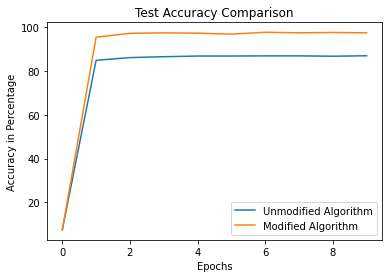

In [ ]:
#training hyperparameters#
trainCycles = 10
seed = 44345434
lr = 0.08
momentum = 0.9
batchSize = 128
splitFreq = 1
showTrainingLoss = False
showSpectrumDuringSplit = False
goodnessOfFitCutoff = 0.1


#network topology setup
dims = [28*28, 1000, 10]
no_rel = [False for i in range(len(dims))] #Layers without relu

alg = 0

if __name__ == '__main__':
  use_cuda = not False and torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu:1")
  torch.manual_seed(seed)
  model = networkModel(no_rel,dims)
  model.to(device)
  (args, model,optimizer, test_loader, train_loader) = neuralInit(seed, device, model, lr, momentum, batchSize)

x,y2,y = [], [], []
model2 = copy.deepcopy(model)
model2.to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=args['lr'], momentum=args['momentum'])
x.append(0)
initial = test(args, model, device, test_loader)
y.append(initial)
y2.append(initial)

for epoch in range(1,trainCycles):
  #split every splitFreq many cycles
  if epoch % splitFreq == 0 and epoch != 0:
    model2 = splitWrapper(model2, device, epoch,goodnessOfFitCutoff, show = showSpectrumDuringSplit,  alg=alg)
    optimizer2 = optim.SGD(model2.parameters(), lr=args['lr'], momentum=args['momentum'])
  
  train(args, model, device, train_loader, optimizer, epoch, showTrainingLoss)
  train(args, model2, device, train_loader, optimizer2, epoch, showTrainingLoss)

  x.append(epoch)
  print("unmodified test score")
  y.append(test(args, model, device, test_loader))
  print("modified test score")
  y2.append(test(args, model2, device, test_loader))




plt.title("Test Accuracy Comparison")
plt.plot(x,y, label = "Unmodified Algorithm")
plt.plot(x,y2, label = "Modified Algorithm")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy in Percentage")
plt.show()

running the block below generates figure 4 and figure 5 from the paper

test set: Average loss: 292.477746, Accuracy: 787/10000 (8%)
unmodified test score at epoch,  1
test set: Average loss: 18.568414, Accuracy: 9572/10000 (96%)
unmodified test score at epoch,  2
test set: Average loss: 12.076134, Accuracy: 9695/10000 (97%)
unmodified test score at epoch,  3
test set: Average loss: 9.914458, Accuracy: 9750/10000 (98%)
unmodified test score at epoch,  4
test set: Average loss: 9.683138, Accuracy: 9748/10000 (97%)
unmodified test score at epoch,  5
test set: Average loss: 8.573669, Accuracy: 9796/10000 (98%)
unmodified test score at epoch,  6
test set: Average loss: 8.075497, Accuracy: 9794/10000 (98%)
unmodified test score at epoch,  7
test set: Average loss: 7.606766, Accuracy: 9815/10000 (98%)
unmodified test score at epoch,  8
test set: Average loss: 7.254691, Accuracy: 9821/10000 (98%)
unmodified test score at epoch,  9
test set: Average loss: 6.933496, Accuracy: 9832/10000 (98%)
unmodified test score at epoch,  10
test set: Average loss: 6.926508, Acc

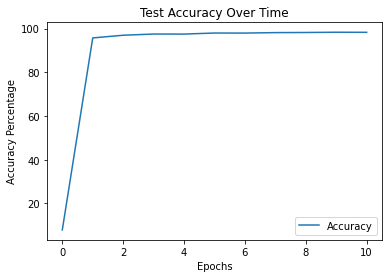

predicted rank: 56
cutting. at this epoch we keep 0.45
error 0.010176411772413685


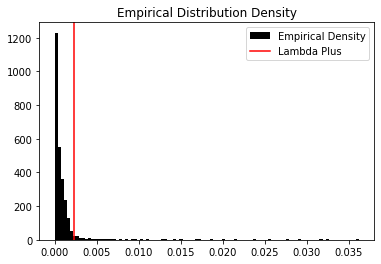

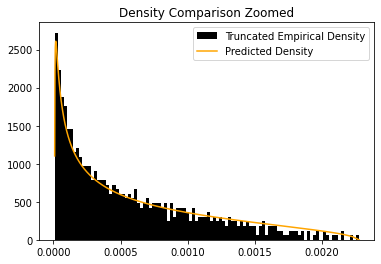

error 0.7


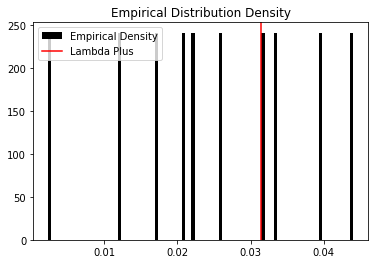

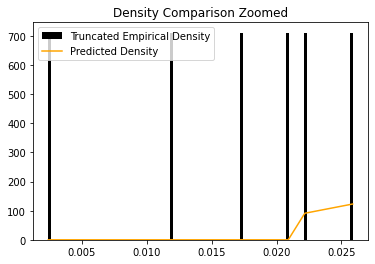

New Dimensions: [784, 1000, 10]
full model accuracy
test set: Average loss: 6.926508, Accuracy: 9829/10000 (98%)
test set: Average loss: 352.274317, Accuracy: 892/10000 (9%)
test set: Average loss: 305.754641, Accuracy: 5459/10000 (55%)
test set: Average loss: 197.882803, Accuracy: 7575/10000 (76%)
test set: Average loss: 112.256428, Accuracy: 8464/10000 (85%)
test set: Average loss: 51.392296, Accuracy: 9071/10000 (91%)
test set: Average loss: 20.647719, Accuracy: 9545/10000 (95%)
test set: Average loss: 12.350332, Accuracy: 9729/10000 (97%)
test set: Average loss: 9.756476, Accuracy: 9773/10000 (98%)
test set: Average loss: 8.554631, Accuracy: 9802/10000 (98%)
test set: Average loss: 7.597202, Accuracy: 9826/10000 (98%)
test set: Average loss: 7.279949, Accuracy: 9821/10000 (98%)
test set: Average loss: 7.239936, Accuracy: 9822/10000 (98%)
test set: Average loss: 7.166526, Accuracy: 9823/10000 (98%)
test set: Average loss: 7.093342, Accuracy: 9826/10000 (98%)
test set: Average loss: 

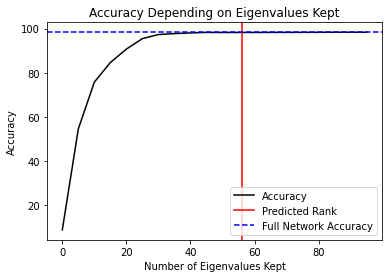

In [ ]:
#training hyperparameters#
trainCycles = 10
seed = 43554454
lr = 0.08
momentum = 0.9
batchSize = 128
showTrainingLoss = False
goodnessOfFitCutoff = 0.1


#network topology setup
dims = [28*28, 1000, 10]
no_rel = [False for i in range(len(dims))] #Layers without relu


if __name__ == '__main__':
  use_cuda = not False and torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu:1")
  torch.manual_seed(seed)
  model = networkModel(no_rel,dims)
  model.to(device)
  (args, model,optimizer, test_loader, train_loader) = neuralInit(seed, device, model, lr, momentum, batchSize)

x,y = [], []
x.append(0)
initial = test(args, model, device, test_loader)
y.append(initial)

for epoch in range(1,trainCycles+1):
  train(args, model, device, train_loader, optimizer, epoch, showTrainingLoss)

  x.append(epoch)
  print("unmodified test score at epoch, ", epoch)
  y.append(test(args, model, device, test_loader))

plt.title("Test Accuracy Over Time")
plt.plot(x,y, label = "Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy Percentage")
plt.show()

modelCopy = copy.deepcopy(model)
predictedRank = computePredictedRank(modelCopy, 0)
print("predicted rank:", predictedRank)
splitWrapper(modelCopy, device, epoch,goodnessOfFitCutoff, show = True,  alg=-1)

print("full model accuracy")
test(args, modelCopy, device, test_loader)
eigs = []
acc = []

for i in range(0,100,5):
  modelCopy = copy.deepcopy(model)
  splitModel, change = innerAlgWrapper(modelCopy, 0, 1000 ,i, True, alg=1)
  splitModel.to(device)
  eigs.append(i)
  acc.append(test(args, splitModel,device, test_loader))

plt.plot(eigs,acc, label = "Accuracy", color="black")
plt.title("Accuracy Depending on Eigenvalues Kept")
plt.xlabel("Number of Eigenvalues Kept")
plt.ylabel("Accuracy")
plt.axvline(x = predictedRank, label = "Predicted Rank", color= "red")
plt.axhline(y = y[-1], label = "Full Network Accuracy", color= "blue", linestyle = "dashed")
plt.legend()
plt.show()